In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from utils import to_grayscale_then_rgb
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Lambda
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split

In [6]:
file_data_b_csv=r'/home/jacobo15defrutos/AVS9/4-Red_Siamesa/Code/seg2_RS.csv'
df= pd.read_csv(file_data_b_csv)
df_train, df_test = train_test_split(df, test_size=0.2,random_state=41)
print("Train shape: ",df_train.shape)
print("Test shape: ",df_test.shape)

Train shape:  (65, 3)
Test shape:  (17, 3)


In [3]:
labels_train= df_train['Label']
train_list_OI=[]
train_list_OD=[]
target_size = (224, 224)
folder= r'/home/jacobo15defrutos/AVS9/Data/fotos_segm2/'
for name in df_train['OI']:
    path= folder + name
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE
    img= cv2.resize(img,target_size)
    train_list_OI.append(img)
for name in df_train['OD']:
    path= folder + name
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE
    img= cv2.resize(img,target_size)
    train_list_OD.append(img)
train_OI= np.array(train_list_OI)
train_OD= np.array(train_list_OD)


# Convert the original labels to one-hot encoded labels
y_train = np.zeros((labels_train.shape[0], 2))
y_train[np.arange(labels_train.shape[0]), labels_train] = 1
x_train_OI= train_OI/255
x_train_OD= train_OD/255

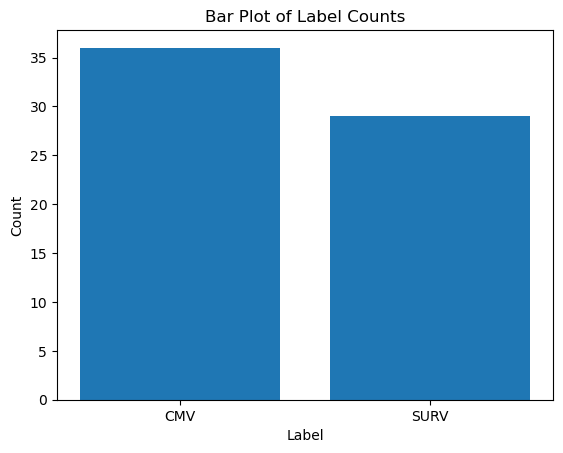

In [4]:
label_counts = df_train['Label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Set the labels and title
plt.xticks(label_counts.index, ["CMV", "SURV"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Label Counts')

# Show the plot
plt.show()

In [ ]:

labels_test= df_test['Label']
test_list_OI=[]
test_list_OD=[]
target_size = (224, 224)
folder= '/home/jacobo15defrutos/AVS9/Data/fotos_segm2/'
for name in df_test['OI']:
    path= folder + name
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)#, cv2.IMREAD_GRAYSCALE
    img= cv2.resize(img,target_size)
    test_list_OI.append(img)
for name in df_test['OD']:
    path= folder + name
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)#, cv2.IMREAD_GRAYSCALE
    img= cv2.resize(img,target_size)
    test_list_OD.append(img)
test_OI= np.array(test_list_OI)
test_OD= np.array(test_list_OD)

x_test_OI= test_OI/255
x_test_OD= test_OD/255
# Convert the original labels to one-hot encoded labels
y_test = np.zeros((labels_test.shape[0], 3))
y_test[np.arange(labels_test.shape[0]), labels_test] = 1
x_test_OI.shape


In [ ]:
label_counts = df_test['Label'].value_counts()

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Set the labels and title
plt.xticks(label_counts.index, ["CMV", "SURV"])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Label Counts')

# Show the plot
plt.show()

In [ ]:
# Definir la arquitectura de LeNet-5

def build_LeNet5_branch(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv2D(6, kernel_size=(5, 5), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    output_layer = Dense(84, activation='relu')(x)
    #output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    

    return model




In [ ]:
#learning_rate=0.001
#input_shape=(224,224,3)
#base_model = VGG19(weights='imagenet',input_shape=input_shape,include_top=True)#,include_top=True
#base_model.get_layer(name='predictions')
# # Remove the original output layer (the 'predictions' layer)
#output_layer = Dense(3, activation='softmax', name='custom_output')(base_model.layers[-1].output)
#model = Model(inputs=base_model.input, outputs=(output_layer))
#model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
def euclidean_distance(vectors):
    feat_a, feat_b = vectors
    squared_distance = tf.reduce_sum(tf.square(feat_a - feat_b), axis=1, keepdims=True)
    return tf.sqrt(squared_distance)

In [ ]:
input_shape=(224, 224, 1)
branch_a= build_LeNet5_branch(input_shape)
branch_b= build_LeNet5_branch(input_shape)
distance_layer= Lambda(euclidean_distance)([branch_a.output,branch_b.output])#F.pairwise_distance
output_layer= Dense(2,activation='sigmoid')(distance_layer)
model = Model(inputs=[branch_a.input, branch_b.input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
x_train=[x_test_OI,x_test_OD]
h=model.fit(x=x_train, y=y_train, batch_size= 1, validation_split=0.15, epochs=100,verbose=1)

In [ ]:
plt.plot(np.log10(h.history['loss']))
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'], 'r')
plt.legend(['train acc', 'val acc'])
print('train acc: %.2f %% \nval acc: %.2f %%'%(h.history['accuracy'][-1]*100,h.history['val_accuracy'][-1]*100))

In [ ]:
x_test= [x_test_OI,x_test_OD]
pred=model.predict(x_test,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

In [ ]:
from sklearn.metrics import accuracy_score
labels=df_test['Label'].astype(int).tolist()
accuracy_score(labels,predicted_class_indices)